# Graph Neural Networks for Link Prediction 

Refer to this [blog post](https://medium.com/@tanishjain/224w-final-project-46c1054f2aa4) for more details!

## Installing the required Python packages

In [ ]:
# !pip install torch-scatter 
# !pip install torch-sparse 
!pip install torch-geometric #to install Python-Geometric (pyg)!
!pip install -q git+https://github.com/snap-stanford/deepsnap.git
!pip install -U -q PyDrive
!pip install ogb #needed for the dataset

## Import the necessary Python modules

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as pyg
from torch_geometric.data import DataLoader
from torch_geometric.utils import negative_sampling
from ogb.linkproppred import PygLinkPropPredDataset, Evaluator #needed to extract and evaluate the ogb-ddi dataset
import matplotlib.pyplot as plt #needed to visualize loss curves
import numpy as np 

## Graph Neural Network

We are going to be using a GNN with a few layers of GraphSAGE convolution for message passing

In [3]:
class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout, emb=False):
        super(GNNStack, self).__init__()
        conv_model = pyg.nn.SAGEConv

        self.convs = nn.ModuleList()
        self.convs.append(conv_model(input_dim, hidden_dim))
        self.dropout = dropout
        self.num_layers = num_layers
        self.emb = emb

        # Create num_layers GraphSAGE convs
        assert (self.num_layers >= 1), 'Number of layers is not >=1'
        for l in range(self.num_layers - 1):
            self.convs.append(conv_model(hidden_dim, hidden_dim))

        # post-message-passing processing 
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(self.dropout),
            nn.Linear(hidden_dim, output_dim))

    def forward(self, x, edge_index):
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.post_mp(x)

        # Return final layer of embeddings if specified
        if self.emb:
            return x

        # Else return class probabilities
        return F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

The LinkPredictor takes the embedding vector of 2 nodes ($h_i$, $h_j \in \mathbb{R}^d$ ) and computes the probability score of whether there exists a link between the 2 nodes.

$$\text{Probability of edge between node i and node j = MLP}(h_i\odot h_j)$$

Note: $x \odot y$ is the element-wise product (Hadamard product) of vectors $x$ and $y$

In [4]:
class LinkPredictor(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout):
        super(LinkPredictor, self).__init__()

        # Create linear layers
        self.lins = nn.ModuleList()
        self.lins.append(nn.Linear(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.lins.append(nn.Linear(hidden_channels, hidden_channels))
        self.lins.append(nn.Linear(hidden_channels, out_channels))

        self.dropout = dropout

    def reset_parameters(self):
        for lin in self.lins:
            lin.reset_parameters()

    def forward(self, x_i, x_j):
        # x_i and x_j are both of shape (E, D)
        x = x_i * x_j
        for lin in self.lins[:-1]:
            x = lin(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lins[-1](x)
        return torch.sigmoid(x)

A GNN is trained by jointly maximizing the probabilty prediction of correct edges and minimizing the probability prediciton of the incorrect edges:

$Loss = -\log(prob\_pos\_edges  + ϵ) - \log(1-prob\_neg\_edges + ϵ)$ where the $ϵ=10^{-15}$ is added to each term for numerical stability

In [5]:
def train(model, link_predictor, emb, edge_index, pos_train_edge, batch_size, optimizer):
    """
    Runs offline training for model, link_predictor and node embeddings given the message
    edges and supervision edges.
    :param model: Torch Graph model used for updating node embeddings based on message passing
    :param link_predictor: Torch model used for predicting whether edge exists or not
    :param emb: (N, d) Initial node embeddings for all N nodes in graph
    :param edge_index: (2, E) Edge index for all edges in the graph
    :param pos_train_edge: (PE, 2) Positive edges used for training supervision loss
    :param batch_size: Number of positive (and negative) supervision edges to sample per batch
    :param optimizer: Torch Optimizer to update model parameters
    :return: Average supervision loss over all positive (and correspondingly sampled negative) edges
    """
    model.train()
    link_predictor.train()

    train_losses = []

    for edge_id in DataLoader(range(pos_train_edge.shape[0]), batch_size, shuffle=True):
        optimizer.zero_grad()

        # Run message passing on the inital node embeddings to get updated embeddings
        node_emb = model(emb, edge_index)  # (N, d)

        # Predict the class probabilities on the batch of positive edges using link_predictor
        pos_edge = pos_train_edge[edge_id].T  # (2, B)
        pos_pred = link_predictor(node_emb[pos_edge[0]], node_emb[pos_edge[1]])  # (B, )

        # Sample negative edges (same number as number of positive edges) and predict class probabilities 
        neg_edge = negative_sampling(edge_index, num_nodes=emb.shape[0],
                                     num_neg_samples=edge_id.shape[0], method='dense')  # (Ne,2)
        neg_pred = link_predictor(node_emb[neg_edge[0]], node_emb[neg_edge[1]])  # (Ne,)

        # Compute the corresponding negative log likelihood loss on the positive and negative edges
        loss = -torch.log(pos_pred + 1e-15).mean() - torch.log(1 - neg_pred + 1e-15).mean()

        # Backpropagate and update parameters
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
    return sum(train_losses) / len(train_losses)

The performance of a link predictor is evaluated through the metric Hits@K.

Hits@K = Fraction of correct links in the top K links (with respect to their scores) 

Note that a smaller K is a stricter metric.

In [6]:
def test(model, predictor, emb, edge_index, split_edge, batch_size, evaluator):
    """
    Evaluates graph model on validation and test edges
    :param model: Torch Graph model used for updating node embeddings based on message passing
    :param predictor: Torch model used for predicting whether edge exists or not
    :param emb: (N, d) Initial node embeddings for all N nodes in graph
    :param edge_index: (2, E) Edge index for all edges in the graph
    :param split_edge: Dictionary of (e, 2) edges for val pos/neg and test pos/neg edges
    :param batch_size: Number of positive (and negative) supervision edges to sample per batch
    :param evaluator: OGB evaluator to calculate hits @ k metric
    :return: hits @ k results
    """
    model.eval()
    predictor.eval()

    node_emb = model(emb, edge_index)

    pos_valid_edge = split_edge['valid']['edge'].to(emb.device)
    neg_valid_edge = split_edge['valid']['edge_neg'].to(emb.device)
    pos_test_edge = split_edge['test']['edge'].to(emb.device)
    neg_test_edge = split_edge['test']['edge_neg'].to(emb.device)

    pos_valid_preds = []
    for perm in DataLoader(range(pos_valid_edge.size(0)), batch_size):
        edge = pos_valid_edge[perm].t()
        pos_valid_preds += [predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu()]
    pos_valid_pred = torch.cat(pos_valid_preds, dim=0)

    neg_valid_preds = []
    for perm in DataLoader(range(neg_valid_edge.size(0)), batch_size):
        edge = neg_valid_edge[perm].t()
        neg_valid_preds += [predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu()]
    neg_valid_pred = torch.cat(neg_valid_preds, dim=0)

    pos_test_preds = []
    for perm in DataLoader(range(pos_test_edge.size(0)), batch_size):
        edge = pos_test_edge[perm].t()
        pos_test_preds += [predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu()]
    pos_test_pred = torch.cat(pos_test_preds, dim=0)

    neg_test_preds = []
    for perm in DataLoader(range(neg_test_edge.size(0)), batch_size):
        edge = neg_test_edge[perm].t()
        neg_test_preds += [predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu()]
    neg_test_pred = torch.cat(neg_test_preds, dim=0)

    results = {}
    for K in [20, 50, 100]:
        evaluator.K = K
        valid_hits = evaluator.eval({
            'y_pred_pos': pos_valid_pred,
            'y_pred_neg': neg_valid_pred,
        })[f'hits@{K}']
        test_hits = evaluator.eval({
            'y_pred_pos': pos_test_pred,
            'y_pred_neg': neg_test_pred,
        })[f'hits@{K}']

        results[f'Hits@{K}'] = (valid_hits, test_hits)

    return results

## The OGB-ddi Dataset

In [7]:
dataset = PygLinkPropPredDataset(name="ogbl-ddi", root='./dataset/') #download the dataset

Downloaded 0.04 GB: 100%|██████████| 46/46 [00:02<00:00, 17.38it/s]


Extracting ./dataset/ddi.zip


Processing...


Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 1/1 [00:00<00:00, 37.83it/s]


Converting graphs into PyG objects...


100%|██████████| 1/1 [00:00<00:00, 1989.71it/s]

Saving...



Done!


In [8]:
# Hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optim_wd = 0
epochs = 300
hidden_dim = 256
dropout = 0.3
num_layers = 2
lr = 3e-3
node_emb_dim = 256
batch_size = 64 * 1024

/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1: loss: 1.34039
Epoch 2: loss: 1.02461
Epoch 3: loss: 0.86267
Epoch 4: loss: 0.79121
Epoch 5: loss: 0.74283
Epoch 6: loss: 0.70655
Epoch 7: loss: 0.6738
Epoch 8: loss: 0.64655
Epoch 9: loss: 0.61803
Epoch 10: loss: 0.59615
{'Hits@20': (0.1984508086808651, 0.12352328656293778), 'Hits@50': (0.26825431308946807, 0.23291806815542854), 'Hits@100': (0.33707646322917995, 0.3151720366472144)}
Epoch 11: loss: 0.5723
Epoch 12: loss: 0.55679
Epoch 13: loss: 0.54253
Epoch 14: loss: 0.5304
Epoch 15: loss: 0.51965
Epoch 16: loss: 0.50989
Epoch 17: loss: 0.49962
Epoch 18: loss: 0.49228
Epoch 19: loss: 0.48054
Epoch 20: loss: 0.4731
{'Hits@20': (0.21224220722306708, 0.12440725453033584), 'Hits@50': (0.31213058753904815, 0.23643895751709879), 'Hits@100': (0.38644382683217343, 0.3578422192090734)}
Epoch 21: loss: 0.46506
Epoch 22: loss: 0.45562
Epoch 23: loss: 0.45094
Epoch 24: loss: 0.44422
Epoch 25: loss: 0.43729
Epoch 26: loss: 0.43003
Epoch 27: loss: 0.42336
Epoch 28: loss: 0.41591
Epoch 29: 

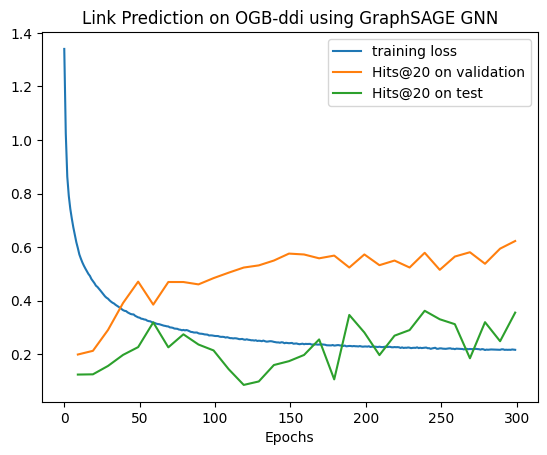

In [9]:
split_edge = dataset.get_edge_split()
pos_train_edge = split_edge['train']['edge'].to(device)

graph = dataset[0]
edge_index = graph.edge_index.to(device)

evaluator = Evaluator(name='ogbl-ddi')

emb = torch.nn.Embedding(graph.num_nodes, node_emb_dim).to(device) # each node has an embedding that has to be learnt
model = GNNStack(node_emb_dim, hidden_dim, hidden_dim, num_layers, dropout, emb=True).to(device) # the graph neural network that takes all the node embeddings as inputs to message pass and agregate
link_predictor = LinkPredictor(hidden_dim, hidden_dim, 1, num_layers + 1, dropout).to(device) # the MLP that takes embeddings of a pair of nodes and predicts the existence of an edge between them

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(link_predictor.parameters()) + list(emb.parameters()),
    lr=lr, weight_decay=optim_wd
)

train_loss = []
val_hits = []
test_hits = []
for e in range(epochs):
    loss = train(model, link_predictor, emb.weight, edge_index, pos_train_edge, batch_size, optimizer)
    print(f"Epoch {e + 1}: loss: {round(loss, 5)}")
    train_loss.append(loss)

    if (e+1)%10 ==0:
        result = test(model, link_predictor, emb.weight, edge_index, split_edge, batch_size, evaluator)
        val_hits.append(result['Hits@20'][0])
        test_hits.append(result['Hits@20'][1])
        print(result)

plt.title('Link Prediction on OGB-ddi using GraphSAGE GNN')
plt.plot(train_loss,label="training loss")
plt.plot(np.arange(9,epochs,10),val_hits,label="Hits@20 on validation")
plt.plot(np.arange(9,epochs,10),test_hits,label="Hits@20 on test")
plt.xlabel('Epochs')
plt.legend()
plt.show()

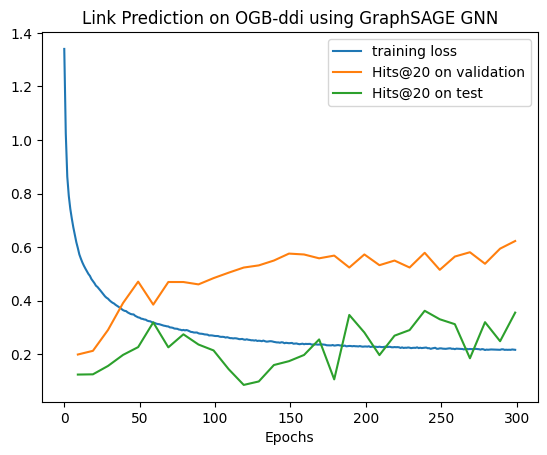

In [10]:
plt.title('Link Prediction on OGB-ddi using GraphSAGE GNN')
plt.plot(train_loss,label="training loss")
plt.plot(np.arange(9,epochs,10),val_hits,label="Hits@20 on validation")
plt.plot(np.arange(9,epochs,10),test_hits,label="Hits@20 on test")
plt.xlabel('Epochs')
plt.legend()
plt.show()

# Online Link Prediction

Preprocess the dataset to the online setting. Basically each online node is stored with a collection of its message passing, supervison, validation and test edges, as well as negative edges. This is all stored nicely in a dictionary for the convenience of the subsequent online link prediciton functions.

In [ ]:
import pickle

class NoEdgeException(Exception):
    pass


def create_online_edge_index(n_id, full_edge_index, curr_edge_index, curr_nodes, rng,
                             train_msg=0.4, train_sup=0.4, val_pct=0.1):
    """
    Creates the train/val/test positive and negative edge index for online node id n_id,
    given the split ratios for training message/supervision, and val and test edges
    :param n_id: Node index for the online node being considered
    :param full_edge_index: (2, E) tensor of ALL edges in the full graph
    :param curr_edge_index: (2, Ec) tensor of edges in the current subgraph
    :param curr_nodes: (N,) tensor of node indices in the current subgraph
    :param rng: numpy random number generator
    :param train_msg: Percentage of n_id's edges that will be used for train message passing
    :param train_sup: Percentage of n_id's edges that will be used for train loss supervision
    :param val_pct: Percentage of n_id's edges that will be used for validation metrics
    :return:
        (2, E_new) tensor of edges in the subgraph updated with node n_id's message edges
        (N+1,) tensor of nodes in the subgraph updated with node n_id
        dict(key, (E, 2) Tensor) of train msg/sup/neg edges, val pos/neg edges, test pos/neg edges
    """
    curr_edges = curr_edge_index.T  # (CE, 2)
    edges = full_edge_index.T  # (E, 2)

    # First search for all edges containing node id
    # since undirected, both (i,j) and (j, i) should be in edges
    all_node_edges = edges[edges[:, 0] == n_id]  # (D_all, 2)

    # Then, only keep edges from node_id to nodes in current graph
    node_edges = torch.isin(all_node_edges[:, 1], curr_nodes)  # (D_all,)
    node_edges = all_node_edges[node_edges]  # (D, 2)
    node_edges = node_edges[rng.permutation(node_edges.shape[0])]  # (D, 2)
    D = node_edges.shape[0]

    # Create negative edges
    neg_edges = []
    for n in curr_nodes:
        if not torch.isin(n, node_edges):
            neg_edges.append((n_id, n))
    neg_edges = torch.as_tensor(neg_edges, dtype=torch.long)  # (Ne, 2)
    neg_edges = neg_edges[rng.permutation(neg_edges.shape[0])]  # (Ne, 2)

    # Then, split node edges into train/val/test
    train_msg_range = (0, int(train_msg * D))
    train_sup_range = (train_msg_range[1], train_msg_range[1] + int(train_sup * D))
    val_range = (train_sup_range[1], train_sup_range[1] + int(val_pct * D))
    test_range = (val_range[1], D)

    split = {
        'train_msg': node_edges[train_msg_range[0]:train_msg_range[1]],  # (TrMsg, 2)
        'train_sup': node_edges[train_sup_range[0]:train_sup_range[1]],  # (TrSup, 2)
        'valid': node_edges[val_range[0]:val_range[1]],  # (Val, 2)
        'test': node_edges[test_range[0]:test_range[1]]  # (Test, 2)
    }

    # Keep same number of neg edges for val/test as pos edges, give remaining to train
    val_neg_range = (0, split['valid'].shape[0])
    test_neg_range = (split['valid'].shape[0], split['valid'].shape[0] + split['test'].shape[0])
    train_neg_range = (split['valid'].shape[0] + split['test'].shape[0], neg_edges.shape[0])

    split['valid_neg'] = neg_edges[val_neg_range[0]:val_neg_range[1]]  # (Val, 2)
    split['test_neg'] = neg_edges[test_neg_range[0]:test_neg_range[1]]  # (Val, 2)
    split['train_neg'] = neg_edges[train_neg_range[0]:train_neg_range[1]]  # (Val, 2)

    # Msg edges need both (i,j) and (j,i)
    split['train_msg'] = split['train_msg'].repeat_interleave(2, dim=0)
    split['train_msg'][::2] = split['train_msg'][::2].flip(1)

    for k, edges in split.items():
        if len(edges) == 0:
            raise NoEdgeException(f"Warning: node {n_id} has no {k} edges")
            # print(f"Warning: node {n_id} has no {k} edges")

    return torch.cat((curr_edges, split['train_msg']), dim=0).T, \
           torch.cat((curr_nodes, torch.as_tensor([n_id]))), \
           split


def preprocess(outfile, init_cluster_size=1000, num_online=None, seed=0,
               split_train_msg=0.4, split_train_sp=0.4, split_val=0.1):
    """
    Creates a dataset with an initial subgraph and a dictionary of online nodes
    :param outfile: path to .pkl file where dataset will be saved
    :param init_cluster_size: Number of nodes in initial subgraph
    :param num_online: Number of nodes considered in online setting
    :param seed: Numpy random number generator seed
    :param split_train_msg: Percentage of each online node's edges used for train message passing
    :param split_train_sp: Percentage of each online node's edges used for train loss supervision
    :param split_val: Percentage of each online node's edges used for validation metrics
    :return:
    """
    rng = np.random.default_rng(seed)

    dataset = PygLinkPropPredDataset(name="ogbl-ddi", root='./dataset/')
    split_edge = dataset.get_edge_split()

    graph = dataset[0]
    edge_index = graph.edge_index.T  # (TrE, 2)

    # All train edges are in edge_index. None of val or test edges are in edge_index
    val_edges = split_edge['valid']['edge'].repeat_interleave(2, dim=0)
    val_edges[::2] = val_edges[::2].flip(1)
    test_edges = split_edge['test']['edge'].repeat_interleave(2, dim=0)
    test_edges[::2] = test_edges[::2].flip(1)
    full_index = torch.cat((edge_index, val_edges, test_edges), dim=0)  # (E, 2)

    nodes = np.arange(graph.num_nodes)
    node_map = np.arange(len(nodes))
    rng.shuffle(node_map)

    # old_to_new[i] = new idx of node i in new ordering of nodes
    new_from_old = torch.from_numpy(node_map[node_map])
    old_from_new = torch.from_numpy(node_map)

    # Map edges to new ordering of nodes (where new node 0 = node_map[0])
    full_index = new_from_old[full_index].T  # (2, E)

    # Initial node induced subgraph of all (keeps the interleaved structure)
    init_nodes = torch.arange(init_cluster_size)
    init_edge_index, _ = pyg.utils.subgraph(init_nodes, full_index)  # (2, InitEdges)

    num_online = num_online if num_online is not None else len(nodes) - init_cluster_size
    online_nodes = torch.arange(init_cluster_size, init_cluster_size + num_online)

    # For online nodes, find edges that connect node to current subgraph.
    # Add the online node's training message edges to the current subgraph to update the curr edge_index
    # Add the node's training, val, test edges to the online node dictionary
    curr_nodes = init_nodes
    curr_edge_index = init_edge_index
    online_node_edge_index = {}
    for n in online_nodes.numpy():
        try:
            curr_edge_index, curr_nodes, node_split = \
                create_online_edge_index(n, full_index, curr_edge_index, curr_nodes, rng, split_train_msg,
                                         split_train_sp, split_val)
        except NoEdgeException as e:
            print(str(e))
            continue
        online_node_edge_index[n] = node_split

    # Save the graph info
    dataset = {
        "init_nodes": init_nodes,
        "init_edge_index": init_edge_index,
        "online": online_node_edge_index,
        "full_edge_index": full_index,
    }

    with open(outfile, 'wb') as f:
        pickle.dump(dataset, f)

# ---------------------------------------------------- #
# Hyper parameters 
init_size = 1000
num_online = 10
seed = 0
split_train_msg = 0.4
split_train_sp = 0.4
split_val = 0.1

split_test = round(1.0 - split_train_msg - split_train_sp - split_val,2)
file_name = f"online_init:{init_size}-online_nodes:{num_online}-split:{split_train_msg}_{split_train_sp}_{split_val}_{split_test}-seed:{seed}.pkl"
file_name = os.path.join('dataset', file_name)

preprocess(file_name, init_size, num_online, seed, split_train_msg, split_train_sp, split_val)

/usr/local/lib/python3.7/dist-packages/torch_geometric/data/storage.py:264: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  " to suppress this warning")


The training function for the onlie setting is almost identical to the train function used for conventional link prediction. The only difference lies in the fact that we don't have to sample negative edges for each node as that has already been done and stored by preprocess.py

In [ ]:
def online_train(model, link_predictor, emb, edge_index, pos_train_edge, neg_train_edges,
                 batch_size, optimizer, device):
    """
    Runs training for a single online node given its edges to the existing subgraph
    :param model: Torch Graph model used for updating node embeddings based on message passing
    :param link_predictor: Torch model used for predicting whether edge exists or not
    :param emb: (N+1, d) Initial node embeddings for all N nodes in subgraph, along with new online node
    :param edge_index: (2, E) Edge index for edges in subgraph, along with message edges for online node
    :param pos_train_edge: (PE, 2) Positive edges from online node to subgraph, for supervision loss
    :param neg_train_edges: (NE, 2) All training negative edges from online node to subgraph.
        (Equal number of negative edges will be sampled as the number of positive edges for batch)
    :param batch_size: Number of positive (and negative) supervision edges to sample per batch
    :param optimizer: Torch Optimizer to update model parameters
    :param device: PyTorch device
    :return: Average supervision loss over all positive (and correspondingly sampled negative) edges
    """
    model.train()
    link_predictor.train()

    train_losses = []

    for edge_id in DataLoader(range(pos_train_edge.shape[0]), batch_size, shuffle=True):
        optimizer.zero_grad()

        # Run message passing on the inital node embeddings to get updated embeddings
        node_emb = model(emb, edge_index)  # (N, d)

        # Predict the class probabilities on the batch of positive edges using link_predictor
        pos_edge = pos_train_edge[edge_id].T  # (2, B)
        pos_pred = link_predictor(node_emb[pos_edge[0]], node_emb[pos_edge[1]])  # (B, )

        # Here we are given negative edges, so sample same number as pos edges and predict probabilities
        neg_idx = np.random.choice(len(neg_train_edges), batch_size, replace=False)
        neg_edge = neg_train_edges[torch.from_numpy(neg_idx).to(device)]  # (Ne, 2)
        neg_pred = link_predictor(node_emb[neg_edge[0]], node_emb[neg_edge[1]])  # (Ne,)

        # Compute the corresponding negative log likelihood loss on the positive and negative edges
        loss = -torch.log(pos_pred + 1e-15).mean() - torch.log(1 - neg_pred + 1e-15).mean()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    return sum(train_losses) / len(train_losses)

The online predictor is evaluated in terms its accuracy. Accuracy is a stronger metric that Hits@K, because it demands that each all correct edges, not just rank above the negative edges but have a probabilty score greater than 0.5. Accuracy is used here as, in the context of predicting interactions for a new drug, it makes sense to understand how accurate the predictor is. 

In [ ]:
def online_eval(model, link_predictor, emb, edge_index, pos_edges, neg_edges, batch_size):
    """
    Evaluates model on positive and negative edges for prediction
    :param model: Torch Graph model used for updating node embeddings based on message passing
    :param link_predictor: Torch model used for predicting whether edge exists or not
    :param emb: (N+1, d) Initial node embeddings for all N nodes in subgraph, along with new online node
    :param edge_index: (2, E) Edge index for edges in subgraph, along with message edges for online node
    :param pos_edges: (PE, 2) Positive edges from online node to subgraph (previously unseen)
    :param neg_edges: (PE, 2) Negative edges from online node to subgraph (previously unseen)
    :param batch_size: Number of positive (and negative) supervision edges to sample per batch
    :return: true positives, true negatives, false positives, false negatives, and
        dict(true positive edges, false positive edges, false negative edges)
    """
    model.eval()
    link_predictor.eval()

    tp = 0.
    tn = 0.
    fp = 0.
    fn = 0.
    for edge_id in DataLoader(range(pos_edges.shape[0]), batch_size, shuffle=False, drop_last=False):
        node_emb = model(emb, edge_index)  # (N, d)

        pos_edge = pos_edges[edge_id].T  # (2, B)
        pos_pred = link_predictor(node_emb[pos_edge[0]], node_emb[pos_edge[1]]).squeeze()  # (B, )

        tp += (pos_pred >= 0.5).sum().item()
        fn += (pos_pred < 0.5).sum().item()

    for edge_id in DataLoader(range(neg_edges.shape[0]), batch_size, shuffle=False, drop_last=False):
        node_emb = model(emb, edge_index)  # (N, d)

        neg_edge = neg_edges[edge_id].T  # (2, B)
        neg_pred = link_predictor(node_emb[neg_edge[0]], node_emb[neg_edge[1]]).squeeze()  # (B, )

        fp += (neg_pred >= 0.5).sum().item()
        tn += (neg_pred < 0.5).sum().item()

    return tp, tn, fp, fn

In [ ]:
# Hyperparameters for the Online Link Predictor
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

path_to_dataset = './dataset/online_init:1000-online_nodes:10-split:0.4_0.4_0.1_0.1-seed:0.pkl'

hidden_dim = 32
dropout = 0.5
num_layers = 4
optim_wd = 0

init_train_epochs = 200
num_online_steps = 10
init_lr = 1e-2
online_lr = 1e-2
node_emb_dim = 256
init_batch_size = 1024 * 64
online_batch_size = 32

# Get dataset
with open(path_to_dataset, 'rb') as f:
    dataset = pickle.load(f)

init_nodes = dataset['init_nodes'].to(device)
init_edge_index = dataset['init_edge_index'].to(device)
init_pos_train = init_edge_index[:, ::2].to(device)  # Relying on interleaved order

online_node_edge_index = dataset['online']

In [ ]:
# Create embedding, model, and optimizer
emb = torch.nn.Embedding(len(init_nodes) + max(online_node_edge_index) + 1, node_emb_dim).to(device)
model = GNNStack(node_emb_dim, hidden_dim, hidden_dim, num_layers, dropout, emb=True).to(device)
link_predictor = LinkPredictor(hidden_dim, hidden_dim, 1, num_layers + 1, dropout).to(device)

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(link_predictor.parameters()) + list(emb.parameters()),
    lr=init_lr, weight_decay=optim_wd
)

# Train on initial subgraph
for e in range(init_train_epochs):
    loss = train(model, link_predictor, emb.weight[:len(init_nodes)], init_edge_index, init_pos_train.T,
                    init_batch_size, optimizer)
    print(f"Epoch {e + 1}/{init_train_epochs}: Loss = {round(loss, 5)}")

/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1/200: Loss = 1.38843
Epoch 2/200: Loss = 1.38687
Epoch 3/200: Loss = 1.38704
Epoch 4/200: Loss = 1.38615
Epoch 5/200: Loss = 1.38526
Epoch 6/200: Loss = 1.37974
Epoch 7/200: Loss = 1.3456
Epoch 8/200: Loss = 1.28827
Epoch 9/200: Loss = 1.19416
Epoch 10/200: Loss = 1.13167
Epoch 11/200: Loss = 1.08638
Epoch 12/200: Loss = 1.06149
Epoch 13/200: Loss = 1.04959
Epoch 14/200: Loss = 1.0007
Epoch 15/200: Loss = 0.98499
Epoch 16/200: Loss = 0.98627
Epoch 17/200: Loss = 0.94583
Epoch 18/200: Loss = 0.93766
Epoch 19/200: Loss = 0.92103
Epoch 20/200: Loss = 0.92377
Epoch 21/200: Loss = 0.90065
Epoch 22/200: Loss = 0.89054
Epoch 23/200: Loss = 0.88517
Epoch 24/200: Loss = 0.87864
Epoch 25/200: Loss = 0.86316
Epoch 26/200: Loss = 0.86692
Epoch 27/200: Loss = 0.85502
Epoch 28/200: Loss = 0.86308
Epoch 29/200: Loss = 0.84658
Epoch 30/200: Loss = 0.84895
Epoch 31/200: Loss = 0.82895
Epoch 32/200: Loss = 0.8287
Epoch 33/200: Loss = 0.83048
Epoch 34/200: Loss = 0.81398
Epoch 35/200: Loss = 0.826

In [ ]:
# New optimizer for online learning (GraphSAGE parameters are not updated to showcase its indective versatility)
optimizer = torch.optim.Adam(
    list(link_predictor.parameters()) + list(emb.parameters()),
    lr=init_lr, weight_decay=optim_wd
)

curr_nodes = init_nodes
curr_edge_index = init_edge_index  # (2, E)
for n_id, node_split in online_node_edge_index.items():
    train_msg, train_sup, train_neg, valid, valid_neg, test, test_neg = \
        node_split['train_msg'], node_split['train_sup'], node_split['train_neg'], \
        node_split['valid'], node_split['valid_neg'], node_split['test'], node_split['test_neg']

    train_msg = train_msg.to(device)
    train_sup = train_sup.to(device)
    train_neg = train_neg.to(device)
    valid = valid.to(device)
    valid_neg = valid_neg.to(device)
    test = test.to(device)
    test_neg = test_neg.to(device)

    # Add message edges to edge index
    curr_edge_index = torch.cat((curr_edge_index, train_msg.T), dim=1)  # (2, E+Tr_msg)

    # Add new node to list of curr_nodes
    curr_nodes = torch.cat((curr_nodes, torch.as_tensor([n_id], device=device)))
    
    with torch.no_grad():
        emb.weight[n_id] = emb.weight[curr_nodes].mean(dim=0)

    # Nodes are ordered sequentially (online node ids start at len(init_nodes))
    for t in range(num_online_steps):
        loss = online_train(model, link_predictor, emb.weight[:n_id + 1],
                            curr_edge_index, train_sup, train_neg, online_batch_size, optimizer, device)
        print(f"Step {t + 1}/{num_online_steps}: loss = {round(loss, 5)}")

    print(f"For node {n_id}:")
    val_tp, val_tn, val_fp, val_fn = online_eval(model, link_predictor, emb.weight[:n_id + 1],
                                                    curr_edge_index, valid, valid_neg, online_batch_size)

    print(f"VAL accuracy: {(val_tp + val_tn) / (val_tp + val_tn + val_fp + val_fn)}")
    print(f"VAL tp: {val_tp}, fn: {val_fn}, tn: {val_tn}, fp: {val_fp}")

    test_tp, test_tn, test_fp, test_fn = online_eval(model, link_predictor, emb.weight[:n_id + 1],
                                                        curr_edge_index, valid, test_neg, online_batch_size)

    print(f"TEST accuracy: {(test_tp + test_tn) / (test_tp + test_tn + test_fp + test_fn)}")
    print(f"TEST tp: {test_tp}, fn: {test_fn}, tn: {test_tn}, fp: {test_fp}")

Step 1/10: loss = 4.1114
Step 2/10: loss = 2.91577
Step 3/10: loss = 3.63771


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Step 4/10: loss = 1.35106
Step 5/10: loss = 1.32374
Step 6/10: loss = 1.40568
Step 7/10: loss = 1.22564
Step 8/10: loss = 0.97422
Step 9/10: loss = 2.34211
Step 10/10: loss = 1.96541
For node 1000:
VAL accuracy: 0.5
VAL tp: 1.0, fn: 0.0, tn: 0.0, fp: 1.0
TEST accuracy: 0.25
TEST tp: 1.0, fn: 0.0, tn: 0.0, fp: 3.0
Step 1/10: loss = 1.05298
Step 2/10: loss = 1.76331
Step 3/10: loss = 0.98855
Step 4/10: loss = 1.12913
Step 5/10: loss = 1.35803
Step 6/10: loss = 1.28807
Step 7/10: loss = 1.06202
Step 8/10: loss = 1.07357
Step 9/10: loss = 1.02655
Step 10/10: loss = 1.243
For node 1001:
VAL accuracy: 0.5
VAL tp: 1.0, fn: 0.0, tn: 0.0, fp: 1.0
TEST accuracy: 0.25
TEST tp: 1.0, fn: 0.0, tn: 0.0, fp: 3.0
Step 1/10: loss = 1.08468
Step 2/10: loss = 1.1439
Step 3/10: loss = 1.11792
Step 4/10: loss = 1.92636
Step 5/10: loss = 1.65633
Step 6/10: loss = 1.35667
Step 7/10: loss = 1.29188
Step 8/10: loss = 1.11484
Step 9/10: loss = 1.05985
Step 10/10: loss = 1.5319
For node 1002:
VAL accuracy: 0.5
VA